cuda
Reading lines...
Read 377937 sentence pairs
Trimmed to 69964 sentence pairs
Counting words...
Counted words:
ita 13272
eng 6628
['sono impegnata oggi', 'i am busy today']
Reading lines...
Read 377937 sentence pairs
Trimmed to 69964 sentence pairs
Counting words...
Counted words:
ita 13272
eng 6628


C:\Users\isacp\AppData\Local\Temp\ipykernel_28296\1928437631.py:144: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  embedded = torch.tensor(embedded, device=device).float()


1m 11s (- 46m 14s) (1 2%) 3.3916
2m 23s (- 45m 29s) (2 5%) 2.4865
3m 35s (- 44m 16s) (3 7%) 2.1321
4m 46s (- 43m 2s) (4 10%) 1.9019
5m 59s (- 41m 56s) (5 12%) 1.7333
7m 11s (- 40m 43s) (6 15%) 1.6015
8m 18s (- 39m 9s) (7 17%) 1.4936
9m 24s (- 37m 38s) (8 20%) 1.4035
10m 30s (- 36m 11s) (9 22%) 1.3260
11m 36s (- 34m 50s) (10 25%) 1.2571
12m 50s (- 33m 50s) (11 27%) 1.1997
14m 1s (- 32m 44s) (12 30%) 1.1487
15m 13s (- 31m 38s) (13 32%) 1.1030
16m 26s (- 30m 31s) (14 35%) 1.0631
17m 36s (- 29m 20s) (15 37%) 1.0246
18m 46s (- 28m 9s) (16 40%) 0.9909
19m 56s (- 26m 59s) (17 42%) 0.9613
21m 8s (- 25m 50s) (18 45%) 0.9337
22m 19s (- 24m 41s) (19 47%) 0.9061
23m 30s (- 23m 30s) (20 50%) 0.8849
24m 42s (- 22m 21s) (21 52%) 0.8621
25m 50s (- 21m 8s) (22 55%) 0.8419
27m 2s (- 19m 59s) (23 57%) 0.8218
28m 14s (- 18m 49s) (24 60%) 0.8053
29m 25s (- 17m 39s) (25 62%) 0.7907
30m 37s (- 16m 29s) (26 65%) 0.7724
31m 48s (- 15m 18s) (27 67%) 0.7583
32m 59s (- 14m 8s) (28 70%) 0.7469
34m 11s (- 12m 58s) 

<Figure size 640x480 with 0 Axes>

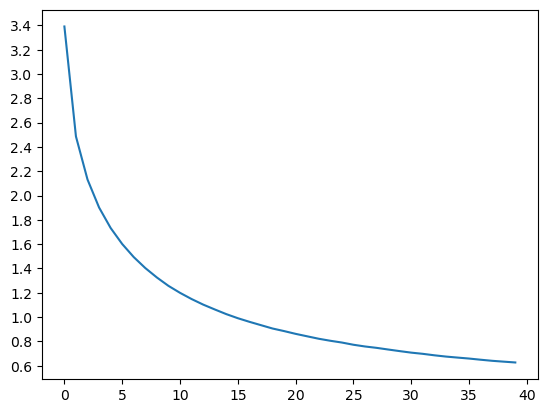

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 5

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'ita', True)
print(random.choice(pairs))

# Train Word2Vec model on the dataset
def train_word2vec(pairs):
    sentences = []
    for pair in pairs:
        sentences.append(pair[0].split(' '))
        sentences.append(pair[1].split(' '))
    # Add special tokens to the vocabulary
    sentences.append(['SOS'])
    sentences.append(['EOS'])
    word2vec_model = Word2Vec(sentences, vector_size=128, window=5, min_count=1, workers=4)
    return word2vec_model

word2vec_model = train_word2vec(pairs)

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, word2vec_model, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.word2vec_model = word2vec_model
        self.embedding_dim = word2vec_model.vector_size
        self.lstm = nn.LSTM(self.embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input_tensor):
        batch_size = input_tensor.size(0)
        embedded = []
        for idx in range(batch_size):
            sentence_embedded = []
            for word_idx in input_tensor[idx]:
                word = input_lang.index2word[word_idx.item()]
                if word in self.word2vec_model.wv:
                    sentence_embedded.append(self.word2vec_model.wv[word])
                else:
                    sentence_embedded.append(np.zeros(self.embedding_dim))
            embedded.append(sentence_embedded)
        embedded = torch.tensor(embedded, device=device).float()
        embedded = self.dropout(embedded)
        outputs, hidden = self.lstm(embedded)
        return outputs, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, word2vec_model, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.word2vec_model = word2vec_model
        self.embedding_dim = word2vec_model.vector_size
        self.attention = BahdanauAttention(hidden_size)
        self.lstm = nn.LSTM(hidden_size + self.embedding_dim, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.tensor(self.word2vec_model.wv['SOS'], device=device).float().unsqueeze(0)
        decoder_input = decoder_input.expand(batch_size, 1, -1)  # Expand to match batch size

        decoder_hidden = encoder_hidden
        decoder_outputs = torch.zeros(batch_size, MAX_LENGTH, self.output_size, device=device)
        attentions = []

        for t in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs[:, t, :] = decoder_output  # Collect the output for each time step
            attentions.append(attn_weights)
            _, topi = decoder_output.topk(1)
            next_word = [output_lang.index2word[topi[i].item()] for i in range(batch_size)]
            decoder_input = torch.tensor([self.word2vec_model.wv[word] if word in self.word2vec_model.wv else np.zeros(self.embedding_dim) for word in next_word], device=device).float().unsqueeze(1)

        attentions = torch.cat(attentions, dim=1)

        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)  # Apply log_softmax to the outputs

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, decoder_input, decoder_hidden, encoder_outputs):
        context, attn_weights = self.attention(decoder_hidden[0].transpose(0, 1), encoder_outputs)
        lstm_input = torch.cat((decoder_input, context), -1)
        decoder_output, decoder_hidden = self.lstm(lstm_input, decoder_hidden)
        output = self.out(decoder_output.squeeze(1))
        return output, decoder_hidden, attn_weights
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'ita', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
                decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        #print(f"decoder_outputs shape: {decoder_outputs.shape}")
        #print(f"target_tensor shape: {target_tensor.shape}")

        # Ensure the shapes are aligned
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
          print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                         epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
            
    return decoded_words, decoder_attn
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(hidden_size, word2vec_model).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, word2vec_model).to(device)

train(train_dataloader, encoder, decoder, 40, print_every=1, plot_every=1)


In [14]:
# Function to get k nearest words using the trained Word2Vec model
def get_k_nearest_words(word, k):
    if word in word2vec_model.wv:
        nearest_words = word2vec_model.wv.most_similar(word, topn=k)
        return nearest_words
    else:
        print(f"'{word}' not in vocabulary!")
        return []

word = "son" 
k = 15  # Number of nearest words to find

nearest_words = get_k_nearest_words(word, k)
print(f"The {k} nearest words to '{word}' are:")
for i, (w, score) in enumerate(nearest_words):
    print(f"{i+1}. {w} (similarity: {score:.4f})")


The 15 nearest words to 'son' are:
1. brother (similarity: 0.9822)
2. father (similarity: 0.9788)
3. wife (similarity: 0.9787)
4. feet (similarity: 0.9751)
5. eyes (similarity: 0.9691)
6. sister (similarity: 0.9668)
7. gift (similarity: 0.9668)
8. future (similarity: 0.9664)
9. hat (similarity: 0.9636)
10. mother (similarity: 0.9607)
11. husband (similarity: 0.9601)
12. nose (similarity: 0.9590)
13. dog (similarity: 0.9582)
14. opinion (similarity: 0.9580)
15. key (similarity: 0.9580)


In [3]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [17]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> io sono colto
= i m cultured
< i m ambidextrous <EOS>

> rendete tutti felici
= make everyone happy
< the everyone happy <EOS>

> siete atletiche
= you re athletic
< you re contagious <EOS>

> perderai tutto
= you ll lose everything
< you know everything everything <EOS>

> la scatola e pesante
= the box is heavy
< the box is heavy <EOS>

> sono alte ?
= are they tall ?
< are they tall ? <EOS>

> tom deve essere ubriaco
= tom must be drunk
< tom must be drunk <EOS>

> sono rossi
= they re red
< i re finicky <EOS>

> legga il testo
= read the text
< i up text <EOS>

> tom comincio a cantare
= tom started to sing
< tom began singing <EOS>

